In [1]:
# Parameters
FUDGE_FACTOR = 1.1200  # 예측값을 곱합니다.

XGB_WEIGHT = 0.6200
BASELINE_WEIGHT = 0.0100
OLS_WEIGHT = 0.0620
NN_WEIGHT = 0.0800

XGB1_WEIGHT = 0.8000  # 두 개의 XGB 모델 조합에서 첫 번째 가중치

BASELINE_PRED = 0.0115   # Oleg당 훈련 데이터의 평균을 기반으로 한 기준선

In [6]:
import numpy as np
import pandas as pd
import gc
import random
import datetime as dt

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb

from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.layers import BatchNormalization

from keras.layers.advanced_activations import PReLU
from keras.layers.noise import GaussianDropout
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor

### PReLU
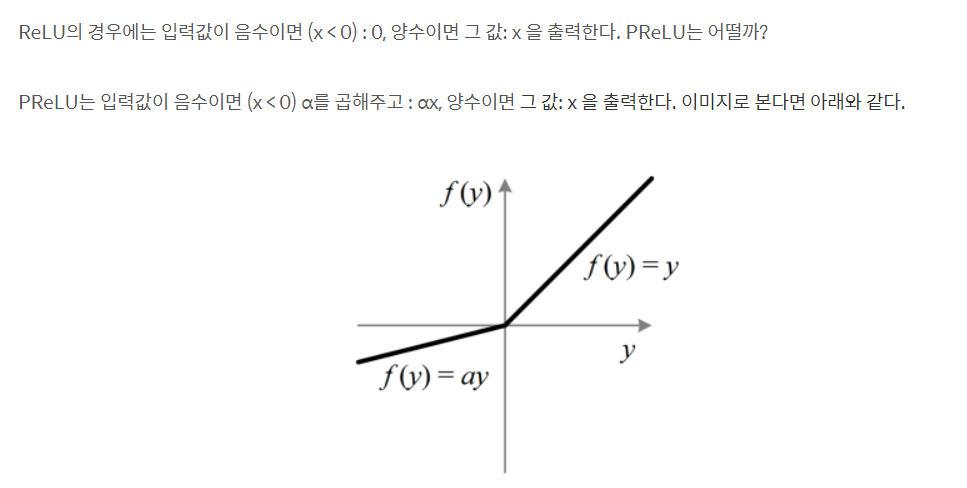

In [10]:
##### READ IN RAW DATA
train = pd.read_csv('./input/train_2016_v2.csv', parse_dates=["transactiondate"])
prop = pd.read_csv('./input/properties_2016.csv')

C:\Users\HOME\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (22,32,34,49,55) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
################
################
##  LightGBM  ##
################
################

##### PROCESS DATA FOR LIGHTGBM
for c, dtype in zip(prop.columns, prop.dtypes):
    if dtype == np.float64:
        prop[c] = prop[c].astype(np.float32)

In [12]:
df_train = train.merge(prop, how='left', on='parcelid')
df_train.fillna(df_train.median(),inplace = True)

C:\Users\HOME\AppData\Local\Temp/ipykernel_5112/2373431120.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_train.fillna(df_train.median(),inplace = True)
C:\Users\HOME\AppData\Local\Temp/ipykernel_5112/2373431120.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_train.fillna(df_train.median(),inplace = True)


In [13]:
x_train = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 
                         'propertycountylandusecode', 'fireplacecnt', 'fireplaceflag'], axis=1)
y_train = df_train['logerror'].values
print(x_train.shape, y_train.shape)

(90275, 53) (90275,)


In [14]:
x_train.dtypes == object

airconditioningtypeid           False
architecturalstyletypeid        False
basementsqft                    False
bathroomcnt                     False
bedroomcnt                      False
buildingclasstypeid             False
buildingqualitytypeid           False
calculatedbathnbr               False
decktypeid                      False
finishedfloor1squarefeet        False
calculatedfinishedsquarefeet    False
finishedsquarefeet12            False
finishedsquarefeet13            False
finishedsquarefeet15            False
finishedsquarefeet50            False
finishedsquarefeet6             False
fips                            False
fullbathcnt                     False
garagecarcnt                    False
garagetotalsqft                 False
hashottuborspa                   True
heatingorsystemtypeid           False
latitude                        False
longitude                       False
lotsizesquarefeet               False
poolcnt                         False
poolsizesum 

In [20]:
x_train.dtypes[x_train.dtypes == object]

hashottuborspa        object
taxdelinquencyflag    object
dtype: object

In [19]:
x_train.dtypes[x_train.dtypes == object].index

Index(['hashottuborspa', 'taxdelinquencyflag'], dtype='object')

In [28]:
x_train.hashottuborspa.unique()

array([1.0], dtype=object)

In [29]:
x_train.taxdelinquencyflag.unique()

array([nan, 'Y'], dtype=object)

In [30]:
train_columns = x_train.columns

for c in x_train.dtypes[x_train.dtypes == object].index.values: # c=['hashottuborspa', 'taxdelinquencyflag']
    x_train[c] = (x_train[c] == True)

del df_train; gc.collect()

x_train = x_train.values.astype(np.float32, copy=False)
d_train = lgb.Dataset(x_train, label=y_train)

In [31]:
##### RUN LIGHTGBM

params = {}
params['max_bin'] = 10
params['learning_rate'] = 0.0021 # 수축율
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'l1'          # or 'mae'
params['sub_feature'] = 0.345    # feature_fraction(작은 값 => 매우 다른 하위 모델 사용)
params['bagging_fraction'] = 0.85 # sub_row
params['bagging_freq'] = 40
params['num_leaves'] = 512        # num_leaf
params['min_data'] = 500         # min_data_in_leaf
params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf
params['verbose'] = 0
params['feature_fraction_seed'] = 2
params['bagging_seed'] = 3

In [32]:
np.random.seed(0)
random.seed(0)

clf = lgb.train(params, d_train, 430)

del d_train; gc.collect()
del x_train; gc.collect()

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

0

In [33]:
sample = pd.read_csv('./input/sample_submission.csv')
sample['parcelid'] = sample['ParcelId']
df_test = sample.merge(prop, on='parcelid', how='left')

del sample, prop
gc.collect()

0

In [34]:
x_test = df_test[train_columns]

del df_test
gc.collect()

for c in x_test.dtypes[x_test.dtypes == object].index.values:
    x_test[c] = (x_test[c] == True)
    
x_test = x_test.values.astype(np.float32, copy=False)

p_test = clf.predict(x_test)

del x_test
gc.collect()

print( pd.DataFrame(p_test).head() )

          0
0  0.031132
1  0.033375
2  0.010257
3  0.008651
4  0.009660


In [35]:
################
################
##  XGBoost   ##
################
################

properties = pd.read_csv('./input/properties_2016.csv')

C:\Users\HOME\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (22,32,34,49,55) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [36]:
for c in properties.columns:
    properties[c]=properties[c].fillna(-1)
    if properties[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(properties[c].values))
        properties[c] = lbl.transform(list(properties[c].values))

In [37]:
##### PROCESS DATA FOR XGBOOST
train_df = train.merge(properties, how='left', on='parcelid')
x_train = train_df.drop(['parcelid', 'logerror','transactiondate'], axis=1)
x_test = properties.drop(['parcelid'], axis=1)

# shape        
print('Shape train: {}\nShape test: {}'.format(x_train.shape, x_test.shape))

Shape train: (90275, 57)
Shape test: (2985217, 57)


In [38]:
# drop out ouliers
train_df=train_df[ train_df.logerror > -0.4 ]
train_df=train_df[ train_df.logerror < 0.419 ]
x_train=train_df.drop(['parcelid', 'logerror','transactiondate'], axis=1)
y_train = train_df["logerror"].values.astype(np.float32)
y_mean = np.mean(y_train)

print('After removing outliers:')     
print('Shape train: {}\nShape test: {}'.format(x_train.shape, x_test.shape))

After removing outliers:
Shape train: (88528, 57)
Shape test: (2985217, 57)


In [39]:
##### RUN XGBOOST
# xgboost params
xgb_params = {
    'eta': 0.037,
    'max_depth': 5,
    'subsample': 0.80,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'lambda': 0.8,   
    'alpha': 0.4, 
    'base_score': y_mean,
    'silent': 1
}

In [40]:
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

In [41]:
num_boost_rounds = 250

# train model
model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=num_boost_rounds)
xgb_pred1 = model.predict(dtest)
print( pd.DataFrame(xgb_pred1).head() )

[15:03:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:03:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


          0
0 -0.030616
1 -0.028188
2  0.026397
3  0.063728
4  0.004398


In [42]:
# xgboost params
xgb_params = {
    'eta': 0.033,
    'max_depth': 6,
    'subsample': 0.80,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'base_score': y_mean,
    'silent': 1
}

num_boost_rounds = 150

model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=num_boost_rounds)
xgb_pred2 = model.predict(dtest)
print( pd.DataFrame(xgb_pred2).head() )

[15:03:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:03:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


          0
0 -0.091150
1 -0.034722
2  0.015816
3  0.075518
4  0.029908


In [43]:
##### COMBINE XGBOOST RESULTS
xgb_pred = XGB1_WEIGHT*xgb_pred1 + (1-XGB1_WEIGHT)*xgb_pred2
print( pd.DataFrame(xgb_pred).head() )

          0
0 -0.042723
1 -0.029495
2  0.024281
3  0.066086
4  0.009500


In [44]:
del train_df
del x_train
del x_test
del properties
del dtest
del dtrain
del xgb_pred1
del xgb_pred2 
gc.collect()

46

In [46]:
######################
######################
##  Neural Network  ##
######################
######################

train = pd.read_csv("./input/train_2016_v2.csv", parse_dates=["transactiondate"])
prop = pd.read_csv('./input/properties_2016.csv')
sample = pd.read_csv('./input/sample_submission.csv')

C:\Users\HOME\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (22,32,34,49,55) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [47]:
for c in prop.columns:
    prop[c]=prop[c].fillna(-1)
    if prop[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(prop[c].values))
        prop[c] = lbl.transform(list(prop[c].values))

In [48]:
df_train = train.merge(prop, how='left', on='parcelid')

df_train["transactiondate"] = pd.to_datetime(df_train["transactiondate"])
df_train["transactiondate_year"] = df_train["transactiondate"].dt.year
df_train["transactiondate_month"] = df_train["transactiondate"].dt.month
df_train['transactiondate_quarter'] = df_train['transactiondate'].dt.quarter
df_train["transactiondate"] = df_train["transactiondate"].dt.day

In [49]:
df_train.fillna(-1.0)
x_train = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode','fireplacecnt', 'fireplaceflag'], axis=1)
y_train = df_train["logerror"]

In [50]:
y_mean = np.mean(y_train)
print(x_train.shape, y_train.shape)
train_columns = x_train.columns

(90275, 56) (90275,)


In [51]:
for c in x_train.dtypes[x_train.dtypes == object].index.values:
    x_train[c] = (x_train[c] == True)

In [52]:
sample['parcelid'] = sample['ParcelId']
df_test = sample.merge(prop, on='parcelid', how='left')

In [53]:
df_test["transactiondate"] = pd.to_datetime('2016-11-15')  # placeholder value for preliminary version
df_test["transactiondate_year"] = df_test["transactiondate"].dt.year
df_test["transactiondate_month"] = df_test["transactiondate"].dt.month
df_test['transactiondate_quarter'] = df_test['transactiondate'].dt.quarter
df_test["transactiondate"] = df_test["transactiondate"].dt.day     
x_test = df_test[train_columns]

In [54]:
for c in x_test.dtypes[x_test.dtypes == object].index.values:
    x_test[c] = (x_test[c] == True)

In [56]:
## Preprocessing
print("\nPreprocessing neural network data...")
imputer= SimpleImputer()
imputer.fit(x_train.iloc[:, :])
x_train = imputer.transform(x_train.iloc[:, :])

imputer.fit(x_test.iloc[:, :])
x_test = imputer.transform(x_test.iloc[:, :])


Preprocessing neural network data...


In [57]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [58]:
len_x=int(x_train.shape[1])
print("len_x is:",len_x)

len_x is: 56


In [59]:
# Neural Network
nn = Sequential()
nn.add(Dense(units = 400 , kernel_initializer = 'normal', input_dim = len_x))
nn.add(PReLU())
nn.add(Dropout(.4))
nn.add(Dense(units = 160 , kernel_initializer = 'normal'))
nn.add(PReLU())
nn.add(BatchNormalization())
nn.add(Dropout(.6))
nn.add(Dense(units = 64 , kernel_initializer = 'normal'))
nn.add(PReLU())
nn.add(BatchNormalization())
nn.add(Dropout(.5))
nn.add(Dense(units = 26, kernel_initializer = 'normal'))
nn.add(PReLU())
nn.add(BatchNormalization())
nn.add(Dropout(.6))
nn.add(Dense(1, kernel_initializer='normal'))
nn.compile(loss='mae', optimizer=Adam(lr=4e-3, decay=1e-4))

C:\Users\HOME\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [60]:
nn.fit(np.array(x_train), np.array(y_train), batch_size = 32, epochs = 70, verbose=2)
y_pred_ann = nn.predict(x_test)
nn_pred = y_pred_ann.flatten()
print( "Type of nn_pred is ", type(nn_pred) )
print( "Shape of nn_pred is ", nn_pred.shape )

print( "\nNeural Network predictions:" )
print( pd.DataFrame(nn_pred).head() )

Epoch 1/70
2822/2822 - 10s - loss: 0.0712 - 10s/epoch - 4ms/step
Epoch 2/70
2822/2822 - 10s - loss: 0.0682 - 10s/epoch - 3ms/step
Epoch 3/70
2822/2822 - 9s - loss: 0.0681 - 9s/epoch - 3ms/step
Epoch 4/70
2822/2822 - 10s - loss: 0.0681 - 10s/epoch - 3ms/step
Epoch 5/70
2822/2822 - 9s - loss: 0.0680 - 9s/epoch - 3ms/step
Epoch 6/70
2822/2822 - 9s - loss: 0.0680 - 9s/epoch - 3ms/step
Epoch 7/70
2822/2822 - 9s - loss: 0.0679 - 9s/epoch - 3ms/step
Epoch 8/70
2822/2822 - 9s - loss: 0.0679 - 9s/epoch - 3ms/step
Epoch 9/70
2822/2822 - 9s - loss: 0.0678 - 9s/epoch - 3ms/step
Epoch 10/70
2822/2822 - 9s - loss: 0.0678 - 9s/epoch - 3ms/step
Epoch 11/70
2822/2822 - 10s - loss: 0.0678 - 10s/epoch - 3ms/step
Epoch 12/70
2822/2822 - 9s - loss: 0.0677 - 9s/epoch - 3ms/step
Epoch 13/70
2822/2822 - 9s - loss: 0.0677 - 9s/epoch - 3ms/step
Epoch 14/70
2822/2822 - 8s - loss: 0.0677 - 8s/epoch - 3ms/step
Epoch 15/70
2822/2822 - 8s - loss: 0.0677 - 8s/epoch - 3ms/step
Epoch 16/70
2822/2822 - 8s - loss: 0.0676

In [61]:
# Cleanup
del train
del prop
del sample
del x_train
del x_test
del df_train
del df_test
del y_pred_ann
gc.collect()

684

In [62]:
################
################
##    OLS     ##
################
################

np.random.seed(17)
random.seed(17)

train = pd.read_csv("./input/train_2016_v2.csv", parse_dates=["transactiondate"])
properties = pd.read_csv("./input/properties_2016.csv")
submission = pd.read_csv("./input/sample_submission.csv")
print(len(train),len(properties),len(submission))

C:\Users\HOME\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (22,32,34,49,55) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


90275 2985217 2985217


In [63]:
def get_features(df):
    df["transactiondate"] = pd.to_datetime(df["transactiondate"])
    df["transactiondate_year"] = df["transactiondate"].dt.year
    df["transactiondate_month"] = df["transactiondate"].dt.month
    df['transactiondate'] = df['transactiondate'].dt.quarter
    df = df.fillna(-1.0)
    return df

def MAE(y, ypred):
    return np.sum([abs(y[i]-ypred[i]) for i in range(len(y))]) / len(y)

In [64]:
train = pd.merge(train, properties, how='left', on='parcelid')
y = train['logerror'].values

test = pd.merge(submission, properties, how='left', left_on='ParcelId', right_on='parcelid')
properties = [] #memory

In [65]:
exc = [train.columns[c] for c in range(len(train.columns)) if train.dtypes[c] == 'O'] + ['logerror','parcelid']
col = [c for c in train.columns if c not in exc]

In [66]:
train = get_features(train[col])
test['transactiondate'] = '2016-01-01' #should use the most common training date
test = get_features(test[col])

C:\Users\HOME\AppData\Local\Temp/ipykernel_5112/379032082.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["transactiondate"] = pd.to_datetime(df["transactiondate"])
C:\Users\HOME\AppData\Local\Temp/ipykernel_5112/379032082.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["transactiondate_year"] = df["transactiondate"].dt.year
C:\Users\HOME\AppData\Local\Temp/ipykernel_5112/379032082.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [67]:
reg = LinearRegression(n_jobs=-1)
reg.fit(train, y); print('fit...')
print(MAE(y, reg.predict(train)))
train = [];  y = [] #memory

fit...
0.06837008699083208


In [68]:
test_dates = ['2016-10-01','2016-11-01','2016-12-01','2017-10-01','2017-11-01','2017-12-01']
test_columns = ['201610','201611','201612','201710','201711','201712']

In [69]:

########################
########################
##  Combine and Save  ##
########################
########################


##### COMBINE PREDICTIONS

print( "\nCombining XGBoost, LightGBM, NN, and baseline predicitons ..." )
XGB_WEIGHT = 0.6200
BASELINE_WEIGHT = 0.0100
OLS_WEIGHT = 0.0620
NN_WEIGHT = 0.0800

lgb_weight = 1 - XGB_WEIGHT - BASELINE_WEIGHT - NN_WEIGHT - OLS_WEIGHT 
lgb_weight0 = lgb_weight / (1 - OLS_WEIGHT)
xgb_weight0 = XGB_WEIGHT / (1 - OLS_WEIGHT)
baseline_weight0 =  BASELINE_WEIGHT / (1 - OLS_WEIGHT)
nn_weight0 = NN_WEIGHT / (1 - OLS_WEIGHT)

pred0 = 0
pred0 += xgb_weight0*xgb_pred
pred0 += baseline_weight0*BASELINE_PRED
pred0 += lgb_weight0*p_test
pred0 += nn_weight0*nn_pred

print( "\nCombined XGB/LGB/NN/baseline predictions:" )
print( pd.DataFrame(pred0).head() )

FUDGE_FACTOR = 1.1200  # 예측값을 곱합니다.
print( "\nPredicting with OLS and combining with XGB/LGB/NN/baseline predicitons: ..." )
for i in range(len(test_dates)): # 6
    test['transactiondate'] = test_dates[i]
    pred = FUDGE_FACTOR * ( OLS_WEIGHT*reg.predict(get_features(test)) + (1-OLS_WEIGHT)*pred0 )
    submission[test_columns[i]] = [float(format(x, '.4f')) for x in pred]
    print('predict...', i)

print( "\nCombined XGB/LGB/NN/baseline/OLS predictions:" )
print( submission.head() )


Combining XGBoost, LightGBM, NN, and baseline predicitons ...

Combined XGB/LGB/NN/baseline predictions:
          0
0 -0.021400
1 -0.012236
2  0.107316
3  0.060956
4  0.022994

Predicting with OLS and combining with XGB/LGB/NN/baseline predicitons: ...
predict... 0
predict... 1
predict... 2
predict... 3
predict... 4
predict... 5

Combined XGB/LGB/NN/baseline/OLS predictions:
   ParcelId  201610  201611  201612  201710  201711  201712
0  10754147 -0.0248 -0.0248 -0.0248 -0.0248 -0.0248 -0.0248
1  10759547 -0.0156 -0.0156 -0.0156 -0.0156 -0.0156 -0.0156
2  10843547  0.1578  0.1578  0.1578  0.1578  0.1578  0.1578
3  10859147  0.0667  0.0667  0.0667  0.0667  0.0667  0.0667
4  10879947  0.0263  0.0263  0.0262  0.0263  0.0263  0.0262


In [70]:
##### WRITE THE RESULTS

from datetime import datetime
submission.to_csv('sub{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)